In [14]:
import numpy as np

def w(i, k, t, x):
    ii=i-1 # re-index to account for python array indexing
    
    if not t[ii]==t[ii+k-1]:
        return (x-t[ii]) / (t[ii+k-1]-t[ii])
    else:
        return 0.0
    
def bspline(i, k, t, x):
    '''
    B_{i,k} (x) on extended knot sequence t (t1, ...., tq)
    where k is the order of the spline
    i is the index of the basis (1...q + p -1)
    where q is len(original_knot sequence)
    p = k-1 (degree of spline)
    
    in order to cope with python indexing will internally shift all indices by 1
    '''
    ii = i-1 # re-index to account for python array indexing
    
    if k==1:
        # piecewise constant
        if t[ii]<=x and x<t[ii+1]:
            return 1.
        else:
            return 0.
        
    else:
        c1 = w(i, k, t, x)
        c2 = 1.-w(i+1, k, t, x)
        return c1 * bspline(i, k-1, t, x) + c2 * bspline(i+1, k-1, t, x) 

In [42]:
p = 3 # spline degree
k = p+1 # spline order

t_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
q = len(t_orig)

# extend knots
t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = np.ones(N) + np.random.normal(0.0, 0.3, N)

coefficients: [0.82316722 0.81702969 1.09252097 0.76375789 1.47371404 1.23980039
 1.0559558 ]


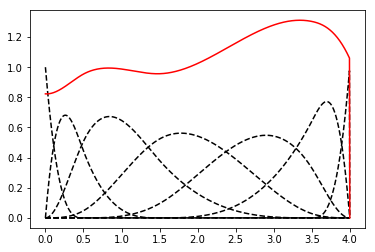

In [44]:
# plot basis
from matplotlib import pyplot as plt

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in xvals])
    yvals_arr.append(yvals)
    plt.plot(xvals, yvals, 'k--')
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
print "coefficients:",c
plt.plot(xvals, yvals, 'r-')

coefficients [-7.40096878  6.60751404 -7.8123763   8.16091583]
knots [-2.  2.]


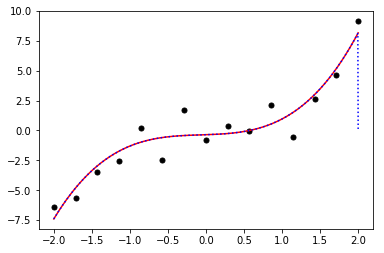

In [79]:
# now check consistency with scipy interpolate
# generate fake data - with noise
np.random.seed(1)

xmin = -2.
xmax = 2.
xobs = np.linspace(xmin, xmax, 15)
stderr = 1.0
yobs = xobs**3+np.random.normal(0.0, stderr, len(xobs))

# now interpolate with scipy
from scipy.interpolate import UnivariateSpline
func = UnivariateSpline(xobs, yobs, s=30, k=p) # scipy denotes degree of spline with k (meh!)
new_x = np.linspace(xmin, xmax, 1000)
new_y = func(new_x)
plt.figure()
plt.plot(xobs, yobs, ".", markersize=10, color='black')
plt.plot(new_x,new_y, "r-")

# now run my own code
print "coefficients", func.get_coeffs()
print "knots", func.get_knots()

t_orig = func.get_knots()
q = len(t_orig)

t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = func.get_coeffs()

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in new_x])
    yvals_arr.append(yvals)
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
plt.plot(xvals, yvals, 'b', linestyle='dotted')